# GAN on lsun dataset

This notebook trains a [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) on the lsun dataset.

The code is adapted from [pytorch's DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich.


In [3]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 2024
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  2024


In [4]:
%matplotlib inline

In [5]:
# Root directory for dataset
dataroot = "../input/lsun_bedroom/data0/lsun/bedroom"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

cuda:0


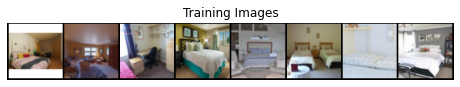

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(4, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
import cupy as cp

def calculate_fid(act1, act2):
     # calculate mean and covariance statistics
     print('calc mean')
     mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
     mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
     # calculate sum squared difference between means
     print('calc sum')
     ssdiff = numpy.sum((mu1 - mu2)**2.0)
     # calculate sqrt of product between cov
     print('calc sqrt')  
     covmean = sqrtm(sigma1.dot(sigma2))
     # check and correct imaginary numbers from sqrt
     if iscomplexobj(covmean):
         print('correct covmean')
         covmean = covmean.real
     # calculate score
     print('calc score')
     fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
     return fid

In [29]:
# test fid score

img = vutils.make_grid(real_batch[0].to(device)[:1], padding=0, normalize=True).cpu().numpy()
act1 = np.transpose(img, (2, 0, 1)).reshape(3,-1)
calculate_fid(act1, act1)

calc mean
calc sum
calc sqrt
correct covmean
calc score


-0.000729742545344502

Starting Training Loop...
[0/5][0/2369]	Loss_D: 0.4686	Loss_G: 9.7921	D(x): 0.7303	D(G(z)): 0.0129 / 0.0001


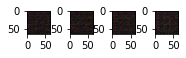

calc mean
calc sum
calc sqrt
correct covmean
calc score
[0/5][50/2369]	Loss_D: 0.5446	Loss_G: 26.0394	D(x): 0.7763	D(G(z)): 0.0000 / 0.0000
[0/5][100/2369]	Loss_D: 2.1851	Loss_G: 6.6195	D(x): 0.3330	D(G(z)): 0.0017 / 0.0041
[0/5][150/2369]	Loss_D: 0.6059	Loss_G: 3.8032	D(x): 0.7402	D(G(z)): 0.1629 / 0.0265
[0/5][200/2369]	Loss_D: 0.4260	Loss_G: 9.0159	D(x): 0.9829	D(G(z)): 0.2800 / 0.0002
[0/5][250/2369]	Loss_D: 0.4437	Loss_G: 5.1397	D(x): 0.8959	D(G(z)): 0.2245 / 0.0133
[0/5][300/2369]	Loss_D: 0.9649	Loss_G: 4.0752	D(x): 0.8328	D(G(z)): 0.4733 / 0.0278
[0/5][350/2369]	Loss_D: 0.7491	Loss_G: 7.8969	D(x): 0.9398	D(G(z)): 0.4427 / 0.0012
[0/5][400/2369]	Loss_D: 0.5147	Loss_G: 3.3545	D(x): 0.8335	D(G(z)): 0.2421 / 0.0534
[0/5][450/2369]	Loss_D: 0.2245	Loss_G: 4.7424	D(x): 0.8832	D(G(z)): 0.0725 / 0.0126
[0/5][500/2369]	Loss_D: 0.3219	Loss_G: 4.9048	D(x): 0.9447	D(G(z)): 0.2184 / 0.0096


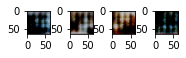

calc mean
calc sum
calc sqrt
correct covmean
calc score
[0/5][550/2369]	Loss_D: 0.9600	Loss_G: 2.2759	D(x): 0.4850	D(G(z)): 0.0369 / 0.1554
[0/5][600/2369]	Loss_D: 0.4625	Loss_G: 3.8464	D(x): 0.8042	D(G(z)): 0.1439 / 0.0335
[0/5][650/2369]	Loss_D: 0.2598	Loss_G: 4.1406	D(x): 0.8648	D(G(z)): 0.0764 / 0.0212
[0/5][700/2369]	Loss_D: 0.4993	Loss_G: 3.8514	D(x): 0.8287	D(G(z)): 0.2202 / 0.0349
[0/5][750/2369]	Loss_D: 0.5910	Loss_G: 3.9243	D(x): 0.6613	D(G(z)): 0.0331 / 0.0335
[0/5][800/2369]	Loss_D: 0.8443	Loss_G: 4.4282	D(x): 0.5204	D(G(z)): 0.0056 / 0.0217
[0/5][850/2369]	Loss_D: 0.3107	Loss_G: 4.8849	D(x): 0.8983	D(G(z)): 0.1491 / 0.0116
[0/5][900/2369]	Loss_D: 0.3079	Loss_G: 4.5439	D(x): 0.8226	D(G(z)): 0.0419 / 0.0204
[0/5][950/2369]	Loss_D: 0.2932	Loss_G: 4.3375	D(x): 0.8541	D(G(z)): 0.1048 / 0.0199
[0/5][1000/2369]	Loss_D: 0.4053	Loss_G: 2.9034	D(x): 0.8022	D(G(z)): 0.0942 / 0.0814


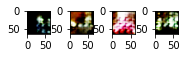

calc mean
calc sum
calc sqrt
correct covmean
calc score
[0/5][1050/2369]	Loss_D: 0.2955	Loss_G: 3.8278	D(x): 0.8291	D(G(z)): 0.0634 / 0.0351
[0/5][1100/2369]	Loss_D: 0.6472	Loss_G: 3.7937	D(x): 0.6115	D(G(z)): 0.0133 / 0.0528
[0/5][1150/2369]	Loss_D: 0.3017	Loss_G: 4.5094	D(x): 0.9364	D(G(z)): 0.1813 / 0.0196
[0/5][1200/2369]	Loss_D: 1.1193	Loss_G: 3.8094	D(x): 0.4472	D(G(z)): 0.0094 / 0.0757
[0/5][1250/2369]	Loss_D: 0.2750	Loss_G: 3.7272	D(x): 0.8496	D(G(z)): 0.0749 / 0.0429
[0/5][1300/2369]	Loss_D: 0.2350	Loss_G: 4.1514	D(x): 0.9139	D(G(z)): 0.1161 / 0.0277
[0/5][1350/2369]	Loss_D: 0.3891	Loss_G: 4.0662	D(x): 0.8296	D(G(z)): 0.1490 / 0.0270
[0/5][1400/2369]	Loss_D: 0.3914	Loss_G: 5.0168	D(x): 0.9589	D(G(z)): 0.2431 / 0.0192
[0/5][1450/2369]	Loss_D: 0.6829	Loss_G: 5.8719	D(x): 0.8996	D(G(z)): 0.3586 / 0.0068
[0/5][1500/2369]	Loss_D: 0.3447	Loss_G: 3.8568	D(x): 0.8736	D(G(z)): 0.1276 / 0.0484


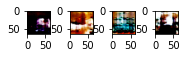

calc mean
calc sum
calc sqrt
correct covmean
calc score
[0/5][1550/2369]	Loss_D: 0.2023	Loss_G: 4.7351	D(x): 0.9044	D(G(z)): 0.0787 / 0.0207
[0/5][1600/2369]	Loss_D: 0.1807	Loss_G: 5.3888	D(x): 0.9520	D(G(z)): 0.1083 / 0.0090
[0/5][1650/2369]	Loss_D: 0.1972	Loss_G: 4.0722	D(x): 0.9327	D(G(z)): 0.1084 / 0.0270
[0/5][1700/2369]	Loss_D: 0.3794	Loss_G: 4.9730	D(x): 0.8869	D(G(z)): 0.1862 / 0.0116
[0/5][1750/2369]	Loss_D: 0.7911	Loss_G: 10.5154	D(x): 0.9642	D(G(z)): 0.4522 / 0.0001
[0/5][1800/2369]	Loss_D: 0.3567	Loss_G: 5.1373	D(x): 0.9105	D(G(z)): 0.2009 / 0.0103
[0/5][1850/2369]	Loss_D: 0.2492	Loss_G: 4.0276	D(x): 0.8929	D(G(z)): 0.0982 / 0.0300
[0/5][1900/2369]	Loss_D: 0.1767	Loss_G: 4.9550	D(x): 0.8966	D(G(z)): 0.0535 / 0.0168
[0/5][1950/2369]	Loss_D: 0.3654	Loss_G: 4.2219	D(x): 0.8781	D(G(z)): 0.1844 / 0.0220
[0/5][2000/2369]	Loss_D: 0.1941	Loss_G: 5.3891	D(x): 0.9399	D(G(z)): 0.1086 / 0.0098


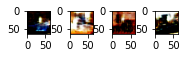

calc mean
calc sum
calc sqrt
correct covmean
calc score
[0/5][2050/2369]	Loss_D: 0.1725	Loss_G: 4.0089	D(x): 0.9143	D(G(z)): 0.0655 / 0.0295
[0/5][2100/2369]	Loss_D: 1.5298	Loss_G: 0.5498	D(x): 0.3388	D(G(z)): 0.0068 / 0.6548
[0/5][2150/2369]	Loss_D: 0.5372	Loss_G: 5.4527	D(x): 0.9584	D(G(z)): 0.3298 / 0.0088
[0/5][2200/2369]	Loss_D: 0.2751	Loss_G: 3.9129	D(x): 0.8510	D(G(z)): 0.0807 / 0.0346
[0/5][2250/2369]	Loss_D: 0.3370	Loss_G: 6.0549	D(x): 0.9626	D(G(z)): 0.2254 / 0.0045
[0/5][2300/2369]	Loss_D: 0.7737	Loss_G: 2.6485	D(x): 0.5510	D(G(z)): 0.0089 / 0.1168
[0/5][2350/2369]	Loss_D: 0.2429	Loss_G: 5.8881	D(x): 0.9428	D(G(z)): 0.1366 / 0.0097
[1/5][0/2369]	Loss_D: 0.3869	Loss_G: 2.6774	D(x): 0.7991	D(G(z)): 0.0966 / 0.1143
[1/5][50/2369]	Loss_D: 0.1820	Loss_G: 4.3637	D(x): 0.9192	D(G(z)): 0.0808 / 0.0235
[1/5][100/2369]	Loss_D: 0.2691	Loss_G: 4.7438	D(x): 0.9050	D(G(z)): 0.1345 / 0.0148


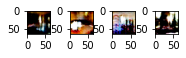

calc mean
calc sum
calc sqrt
correct covmean
calc score
[1/5][150/2369]	Loss_D: 0.2916	Loss_G: 4.1909	D(x): 0.8186	D(G(z)): 0.0561 / 0.0316
[1/5][200/2369]	Loss_D: 0.7973	Loss_G: 6.9336	D(x): 0.8985	D(G(z)): 0.4212 / 0.0021
[1/5][250/2369]	Loss_D: 0.3597	Loss_G: 3.6939	D(x): 0.8377	D(G(z)): 0.1344 / 0.0382
[1/5][300/2369]	Loss_D: 0.2701	Loss_G: 4.1749	D(x): 0.9187	D(G(z)): 0.1493 / 0.0249
[1/5][350/2369]	Loss_D: 0.1680	Loss_G: 4.9162	D(x): 0.9532	D(G(z)): 0.1010 / 0.0132
[1/5][400/2369]	Loss_D: 0.1516	Loss_G: 4.1168	D(x): 0.9044	D(G(z)): 0.0416 / 0.0250
[1/5][450/2369]	Loss_D: 0.5308	Loss_G: 5.0334	D(x): 0.6883	D(G(z)): 0.0162 / 0.0141
[1/5][500/2369]	Loss_D: 0.3461	Loss_G: 3.1888	D(x): 0.7684	D(G(z)): 0.0403 / 0.0629
[1/5][550/2369]	Loss_D: 0.3130	Loss_G: 4.1241	D(x): 0.7756	D(G(z)): 0.0221 / 0.0317
[1/5][600/2369]	Loss_D: 0.2625	Loss_G: 5.2074	D(x): 0.9592	D(G(z)): 0.1809 / 0.0084


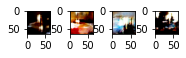

calc mean
calc sum
calc sqrt
correct covmean
calc score
[1/5][650/2369]	Loss_D: 0.2063	Loss_G: 4.1973	D(x): 0.8792	D(G(z)): 0.0529 / 0.0312
[1/5][700/2369]	Loss_D: 0.7661	Loss_G: 3.2694	D(x): 0.5467	D(G(z)): 0.0076 / 0.0744
[1/5][750/2369]	Loss_D: 0.3590	Loss_G: 6.0820	D(x): 0.9324	D(G(z)): 0.2257 / 0.0040
[1/5][800/2369]	Loss_D: 0.6574	Loss_G: 6.3520	D(x): 0.6234	D(G(z)): 0.0014 / 0.0070
[1/5][850/2369]	Loss_D: 0.1455	Loss_G: 5.1837	D(x): 0.8993	D(G(z)): 0.0249 / 0.0112
[1/5][900/2369]	Loss_D: 0.3364	Loss_G: 3.7175	D(x): 0.7705	D(G(z)): 0.0323 / 0.0482
[1/5][950/2369]	Loss_D: 0.1545	Loss_G: 4.9788	D(x): 0.9421	D(G(z)): 0.0794 / 0.0133
[1/5][1000/2369]	Loss_D: 0.2728	Loss_G: 3.7621	D(x): 0.9101	D(G(z)): 0.1190 / 0.0396
[1/5][1050/2369]	Loss_D: 0.1806	Loss_G: 4.7376	D(x): 0.9136	D(G(z)): 0.0672 / 0.0155
[1/5][1100/2369]	Loss_D: 0.3159	Loss_G: 5.9633	D(x): 0.9451	D(G(z)): 0.2070 / 0.0039


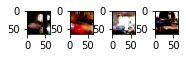

calc mean
calc sum
calc sqrt
correct covmean
calc score
[1/5][1150/2369]	Loss_D: 0.3474	Loss_G: 4.5899	D(x): 0.8869	D(G(z)): 0.1773 / 0.0165
[1/5][1200/2369]	Loss_D: 0.3673	Loss_G: 4.9463	D(x): 0.8917	D(G(z)): 0.1848 / 0.0115
[1/5][1250/2369]	Loss_D: 0.2870	Loss_G: 4.8763	D(x): 0.9207	D(G(z)): 0.1574 / 0.0129
[1/5][1300/2369]	Loss_D: 0.1333	Loss_G: 3.7460	D(x): 0.9376	D(G(z)): 0.0595 / 0.0351
[1/5][1350/2369]	Loss_D: 0.4670	Loss_G: 2.5855	D(x): 0.6918	D(G(z)): 0.0027 / 0.1054
[1/5][1400/2369]	Loss_D: 0.1606	Loss_G: 3.4763	D(x): 0.9071	D(G(z)): 0.0534 / 0.0458
[1/5][1450/2369]	Loss_D: 0.4314	Loss_G: 5.1720	D(x): 0.9123	D(G(z)): 0.2434 / 0.0101
[1/5][1500/2369]	Loss_D: 0.2670	Loss_G: 3.9987	D(x): 0.9046	D(G(z)): 0.1378 / 0.0257
[1/5][1550/2369]	Loss_D: 0.5531	Loss_G: 3.8025	D(x): 0.9817	D(G(z)): 0.3003 / 0.0783
[1/5][1600/2369]	Loss_D: 0.2474	Loss_G: 4.3601	D(x): 0.9018	D(G(z)): 0.1146 / 0.0191


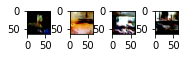

calc mean
calc sum
calc sqrt
correct covmean
calc score
[1/5][1650/2369]	Loss_D: 0.2314	Loss_G: 4.8557	D(x): 0.9573	D(G(z)): 0.1553 / 0.0112
[1/5][1700/2369]	Loss_D: 0.2334	Loss_G: 4.0701	D(x): 0.8513	D(G(z)): 0.0386 / 0.0257
[1/5][1750/2369]	Loss_D: 0.1553	Loss_G: 4.6370	D(x): 0.9668	D(G(z)): 0.1057 / 0.0157
[1/5][1800/2369]	Loss_D: 0.4421	Loss_G: 4.3262	D(x): 0.9468	D(G(z)): 0.2545 / 0.0284
[1/5][1850/2369]	Loss_D: 0.2136	Loss_G: 4.1410	D(x): 0.8686	D(G(z)): 0.0537 / 0.0278
[1/5][1900/2369]	Loss_D: 0.2272	Loss_G: 4.5890	D(x): 0.9548	D(G(z)): 0.1519 / 0.0149
[1/5][1950/2369]	Loss_D: 0.1855	Loss_G: 4.2881	D(x): 0.9178	D(G(z)): 0.0862 / 0.0204
[1/5][2000/2369]	Loss_D: 0.5358	Loss_G: 8.1325	D(x): 0.9732	D(G(z)): 0.3301 / 0.0007
[1/5][2050/2369]	Loss_D: 0.3494	Loss_G: 3.1331	D(x): 0.7904	D(G(z)): 0.0668 / 0.0650
[1/5][2100/2369]	Loss_D: 0.1669	Loss_G: 4.0937	D(x): 0.9581	D(G(z)): 0.1080 / 0.0270


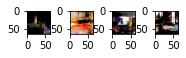

calc mean
calc sum
calc sqrt
correct covmean
calc score
[1/5][2150/2369]	Loss_D: 0.1671	Loss_G: 3.9679	D(x): 0.9408	D(G(z)): 0.0917 / 0.0284
[1/5][2200/2369]	Loss_D: 1.9646	Loss_G: 0.6861	D(x): 0.2407	D(G(z)): 0.0038 / 0.6061
[1/5][2250/2369]	Loss_D: 0.4091	Loss_G: 4.3818	D(x): 0.9205	D(G(z)): 0.2552 / 0.0169
[1/5][2300/2369]	Loss_D: 0.2049	Loss_G: 4.9933	D(x): 0.9493	D(G(z)): 0.1262 / 0.0116
[1/5][2350/2369]	Loss_D: 0.4375	Loss_G: 2.8642	D(x): 0.6945	D(G(z)): 0.0072 / 0.0921
[2/5][0/2369]	Loss_D: 1.6915	Loss_G: 2.7152	D(x): 0.2917	D(G(z)): 0.0009 / 0.1609
[2/5][50/2369]	Loss_D: 0.2966	Loss_G: 5.5413	D(x): 0.9670	D(G(z)): 0.2043 / 0.0061
[2/5][100/2369]	Loss_D: 0.3715	Loss_G: 3.0946	D(x): 0.8184	D(G(z)): 0.1171 / 0.0781
[2/5][150/2369]	Loss_D: 0.4066	Loss_G: 1.8283	D(x): 0.7255	D(G(z)): 0.0418 / 0.2106
[2/5][200/2369]	Loss_D: 0.2402	Loss_G: 4.1216	D(x): 0.9364	D(G(z)): 0.1488 / 0.0245
[2/5][250/2369]	Loss_D: 0.2253	Loss_G: 4.3631	D(x): 0.9319	D(G(z)): 0.1290 / 0.0201


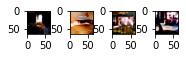

calc mean
calc sum
calc sqrt
correct covmean
calc score
[2/5][300/2369]	Loss_D: 0.3047	Loss_G: 2.9380	D(x): 0.7815	D(G(z)): 0.0223 / 0.0804
[2/5][350/2369]	Loss_D: 0.3158	Loss_G: 3.9449	D(x): 0.8054	D(G(z)): 0.0594 / 0.0330
[2/5][400/2369]	Loss_D: 0.1839	Loss_G: 3.3627	D(x): 0.8977	D(G(z)): 0.0662 / 0.0499
[2/5][450/2369]	Loss_D: 0.2600	Loss_G: 3.3539	D(x): 0.8044	D(G(z)): 0.0182 / 0.0568
[2/5][500/2369]	Loss_D: 0.9527	Loss_G: 7.4836	D(x): 0.8914	D(G(z)): 0.4491 / 0.0014
[2/5][550/2369]	Loss_D: 0.1794	Loss_G: 3.7155	D(x): 0.8892	D(G(z)): 0.0507 / 0.0376
[2/5][600/2369]	Loss_D: 0.1550	Loss_G: 5.3980	D(x): 0.9260	D(G(z)): 0.0671 / 0.0086
[2/5][650/2369]	Loss_D: 0.1898	Loss_G: 2.9213	D(x): 0.8707	D(G(z)): 0.0367 / 0.0795
[2/5][700/2369]	Loss_D: 0.2196	Loss_G: 4.2996	D(x): 0.9283	D(G(z)): 0.1190 / 0.0214
[2/5][750/2369]	Loss_D: 0.1383	Loss_G: 3.7499	D(x): 0.9266	D(G(z)): 0.0541 / 0.0387


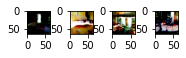

calc mean
calc sum
calc sqrt
correct covmean
calc score
[2/5][800/2369]	Loss_D: 1.0337	Loss_G: 8.2103	D(x): 0.9676	D(G(z)): 0.5378 / 0.0008
[2/5][850/2369]	Loss_D: 0.2279	Loss_G: 3.8463	D(x): 0.9642	D(G(z)): 0.1598 / 0.0315
[2/5][900/2369]	Loss_D: 0.3900	Loss_G: 1.8672	D(x): 0.7351	D(G(z)): 0.0365 / 0.2039
[2/5][950/2369]	Loss_D: 0.1498	Loss_G: 4.2855	D(x): 0.8906	D(G(z)): 0.0257 / 0.0219
[2/5][1000/2369]	Loss_D: 0.4047	Loss_G: 5.5383	D(x): 0.9686	D(G(z)): 0.2662 / 0.0073
[2/5][1050/2369]	Loss_D: 0.2140	Loss_G: 3.6655	D(x): 0.9392	D(G(z)): 0.1304 / 0.0365
[2/5][1100/2369]	Loss_D: 0.2757	Loss_G: 2.0430	D(x): 0.8340	D(G(z)): 0.0689 / 0.1685
[2/5][1150/2369]	Loss_D: 0.4909	Loss_G: 3.6218	D(x): 0.8174	D(G(z)): 0.1803 / 0.0542
[2/5][1200/2369]	Loss_D: 0.4402	Loss_G: 1.8586	D(x): 0.7320	D(G(z)): 0.0819 / 0.2070
[2/5][1250/2369]	Loss_D: 0.1752	Loss_G: 3.8148	D(x): 0.9064	D(G(z)): 0.0669 / 0.0325


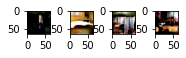

calc mean
calc sum
calc sqrt
correct covmean
calc score
[2/5][1300/2369]	Loss_D: 0.3967	Loss_G: 3.0363	D(x): 0.8239	D(G(z)): 0.1446 / 0.0733
[2/5][1350/2369]	Loss_D: 0.6675	Loss_G: 6.2327	D(x): 0.9919	D(G(z)): 0.4215 / 0.0029
[2/5][1400/2369]	Loss_D: 0.3273	Loss_G: 3.9372	D(x): 0.9070	D(G(z)): 0.1795 / 0.0261
[2/5][1450/2369]	Loss_D: 0.2277	Loss_G: 3.1143	D(x): 0.8941	D(G(z)): 0.0973 / 0.0591
[2/5][1500/2369]	Loss_D: 0.5031	Loss_G: 3.2661	D(x): 0.7999	D(G(z)): 0.1890 / 0.0590
[2/5][1550/2369]	Loss_D: 0.3271	Loss_G: 1.9507	D(x): 0.7914	D(G(z)): 0.0611 / 0.1858
[2/5][1600/2369]	Loss_D: 0.4915	Loss_G: 2.8951	D(x): 0.6892	D(G(z)): 0.0256 / 0.0949
[2/5][1650/2369]	Loss_D: 0.2700	Loss_G: 4.5256	D(x): 0.9680	D(G(z)): 0.1939 / 0.0150
[2/5][1700/2369]	Loss_D: 0.1623	Loss_G: 3.6495	D(x): 0.8946	D(G(z)): 0.0426 / 0.0393
[2/5][1750/2369]	Loss_D: 0.1648	Loss_G: 3.3832	D(x): 0.8907	D(G(z)): 0.0381 / 0.0545


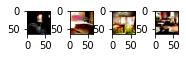

calc mean
calc sum
calc sqrt
correct covmean
calc score
[2/5][1800/2369]	Loss_D: 0.3288	Loss_G: 3.0139	D(x): 0.7887	D(G(z)): 0.0564 / 0.0729
[2/5][1850/2369]	Loss_D: 0.3484	Loss_G: 2.7161	D(x): 0.8394	D(G(z)): 0.1390 / 0.0878
[2/5][1900/2369]	Loss_D: 0.1639	Loss_G: 4.1139	D(x): 0.9146	D(G(z)): 0.0638 / 0.0265
[2/5][1950/2369]	Loss_D: 2.5086	Loss_G: 0.4597	D(x): 0.1529	D(G(z)): 0.0012 / 0.7136
[2/5][2000/2369]	Loss_D: 0.3209	Loss_G: 5.3091	D(x): 0.9508	D(G(z)): 0.2055 / 0.0084
[2/5][2050/2369]	Loss_D: 0.5686	Loss_G: 3.1229	D(x): 0.9736	D(G(z)): 0.3445 / 0.0885
[2/5][2100/2369]	Loss_D: 0.1897	Loss_G: 3.8446	D(x): 0.9418	D(G(z)): 0.1091 / 0.0325
[2/5][2150/2369]	Loss_D: 0.4214	Loss_G: 5.6824	D(x): 0.9634	D(G(z)): 0.2830 / 0.0051
[2/5][2200/2369]	Loss_D: 0.9529	Loss_G: 6.7236	D(x): 0.9782	D(G(z)): 0.5064 / 0.0027
[2/5][2250/2369]	Loss_D: 1.2042	Loss_G: 1.0881	D(x): 0.4033	D(G(z)): 0.0058 / 0.4367


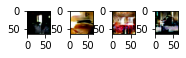

calc mean
calc sum
calc sqrt
correct covmean
calc score
[2/5][2300/2369]	Loss_D: 0.3951	Loss_G: 2.9218	D(x): 0.7986	D(G(z)): 0.1164 / 0.0883
[2/5][2350/2369]	Loss_D: 0.2337	Loss_G: 3.3423	D(x): 0.8671	D(G(z)): 0.0766 / 0.0485
[3/5][0/2369]	Loss_D: 0.1812	Loss_G: 3.8372	D(x): 0.8873	D(G(z)): 0.0479 / 0.0375
[3/5][50/2369]	Loss_D: 2.7627	Loss_G: 9.7534	D(x): 0.9961	D(G(z)): 0.9032 / 0.0001
[3/5][100/2369]	Loss_D: 0.2931	Loss_G: 3.7464	D(x): 0.8755	D(G(z)): 0.1320 / 0.0373
[3/5][150/2369]	Loss_D: 0.2934	Loss_G: 3.1246	D(x): 0.9003	D(G(z)): 0.1497 / 0.0584
[3/5][200/2369]	Loss_D: 0.3090	Loss_G: 4.3196	D(x): 0.9333	D(G(z)): 0.1894 / 0.0192
[3/5][250/2369]	Loss_D: 0.4384	Loss_G: 2.1073	D(x): 0.6998	D(G(z)): 0.0390 / 0.1742
[3/5][300/2369]	Loss_D: 0.1996	Loss_G: 3.9189	D(x): 0.9295	D(G(z)): 0.1113 / 0.0283
[3/5][350/2369]	Loss_D: 0.2389	Loss_G: 3.1203	D(x): 0.8749	D(G(z)): 0.0864 / 0.0648


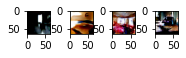

calc mean
calc sum
calc sqrt
correct covmean
calc score
[3/5][400/2369]	Loss_D: 0.2076	Loss_G: 3.0526	D(x): 0.8845	D(G(z)): 0.0716 / 0.0694
[3/5][450/2369]	Loss_D: 0.5628	Loss_G: 5.9813	D(x): 0.9378	D(G(z)): 0.3007 / 0.0054
[3/5][500/2369]	Loss_D: 0.5696	Loss_G: 5.6788	D(x): 0.9595	D(G(z)): 0.3636 / 0.0053
[3/5][550/2369]	Loss_D: 0.2220	Loss_G: 3.4883	D(x): 0.9280	D(G(z)): 0.1225 / 0.0469
[3/5][600/2369]	Loss_D: 0.2037	Loss_G: 4.1560	D(x): 0.9207	D(G(z)): 0.1052 / 0.0206
[3/5][650/2369]	Loss_D: 0.2833	Loss_G: 3.2483	D(x): 0.8722	D(G(z)): 0.1179 / 0.0612
[3/5][700/2369]	Loss_D: 0.4330	Loss_G: 2.4284	D(x): 0.6961	D(G(z)): 0.0158 / 0.1324
[3/5][750/2369]	Loss_D: 0.2350	Loss_G: 3.4695	D(x): 0.8324	D(G(z)): 0.0331 / 0.0485
[3/5][800/2369]	Loss_D: 0.3600	Loss_G: 2.3026	D(x): 0.7560	D(G(z)): 0.0420 / 0.1405
[3/5][850/2369]	Loss_D: 0.1971	Loss_G: 4.2439	D(x): 0.9400	D(G(z)): 0.1192 / 0.0220


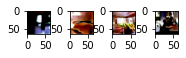

calc mean
calc sum
calc sqrt
correct covmean
calc score
[3/5][900/2369]	Loss_D: 0.1803	Loss_G: 3.9524	D(x): 0.9624	D(G(z)): 0.1216 / 0.0291
[3/5][950/2369]	Loss_D: 0.4872	Loss_G: 1.9343	D(x): 0.7020	D(G(z)): 0.0621 / 0.1957
[3/5][1000/2369]	Loss_D: 0.1520	Loss_G: 3.5311	D(x): 0.9490	D(G(z)): 0.0900 / 0.0408
[3/5][1050/2369]	Loss_D: 0.2436	Loss_G: 3.3633	D(x): 0.8213	D(G(z)): 0.0279 / 0.0518
[3/5][1100/2369]	Loss_D: 0.2103	Loss_G: 3.2219	D(x): 0.8544	D(G(z)): 0.0346 / 0.0671
[3/5][1150/2369]	Loss_D: 1.4595	Loss_G: 6.7360	D(x): 0.9885	D(G(z)): 0.6703 / 0.0028
[3/5][1200/2369]	Loss_D: 0.1852	Loss_G: 3.2635	D(x): 0.8763	D(G(z)): 0.0415 / 0.0564
[3/5][1250/2369]	Loss_D: 0.1639	Loss_G: 3.8473	D(x): 0.9694	D(G(z)): 0.1172 / 0.0296
[3/5][1300/2369]	Loss_D: 2.9454	Loss_G: 0.4003	D(x): 0.1211	D(G(z)): 0.0035 / 0.7237
[3/5][1350/2369]	Loss_D: 0.2433	Loss_G: 4.2016	D(x): 0.9087	D(G(z)): 0.1186 / 0.0234


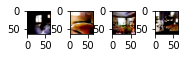

calc mean
calc sum
calc sqrt
correct covmean
calc score
[3/5][1400/2369]	Loss_D: 0.2105	Loss_G: 3.2864	D(x): 0.8657	D(G(z)): 0.0529 / 0.0556
[3/5][1450/2369]	Loss_D: 1.6738	Loss_G: 8.4501	D(x): 0.9929	D(G(z)): 0.7176 / 0.0004
[3/5][1500/2369]	Loss_D: 0.2690	Loss_G: 4.0542	D(x): 0.9507	D(G(z)): 0.1805 / 0.0249
[3/5][1550/2369]	Loss_D: 0.4016	Loss_G: 5.4371	D(x): 0.9663	D(G(z)): 0.2821 / 0.0061
[3/5][1600/2369]	Loss_D: 0.2264	Loss_G: 3.3638	D(x): 0.8341	D(G(z)): 0.0237 / 0.0572
[3/5][1650/2369]	Loss_D: 0.2627	Loss_G: 2.3731	D(x): 0.8097	D(G(z)): 0.0370 / 0.1343
[3/5][1700/2369]	Loss_D: 1.1231	Loss_G: 6.6885	D(x): 0.9716	D(G(z)): 0.5998 / 0.0023
[3/5][1750/2369]	Loss_D: 0.2230	Loss_G: 4.1555	D(x): 0.8650	D(G(z)): 0.0618 / 0.0282
[3/5][1800/2369]	Loss_D: 0.1873	Loss_G: 2.9393	D(x): 0.8852	D(G(z)): 0.0536 / 0.0768
[3/5][1850/2369]	Loss_D: 0.2237	Loss_G: 3.1836	D(x): 0.9205	D(G(z)): 0.1186 / 0.0569


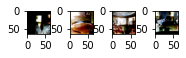

calc mean
calc sum
calc sqrt
correct covmean
calc score
[3/5][1900/2369]	Loss_D: 0.4294	Loss_G: 3.6817	D(x): 0.8531	D(G(z)): 0.1980 / 0.0394
[3/5][1950/2369]	Loss_D: 0.2962	Loss_G: 3.9244	D(x): 0.9668	D(G(z)): 0.2148 / 0.0275
[3/5][2000/2369]	Loss_D: 0.6570	Loss_G: 5.4163	D(x): 0.9647	D(G(z)): 0.4123 / 0.0066
[3/5][2050/2369]	Loss_D: 0.2058	Loss_G: 3.4506	D(x): 0.8920	D(G(z)): 0.0752 / 0.0472
[3/5][2100/2369]	Loss_D: 7.3293	Loss_G: 4.6178	D(x): 0.9976	D(G(z)): 0.9886 / 0.0291
[3/5][2150/2369]	Loss_D: 0.3424	Loss_G: 3.9234	D(x): 0.9240	D(G(z)): 0.2054 / 0.0282
[3/5][2200/2369]	Loss_D: 0.1727	Loss_G: 3.8195	D(x): 0.9044	D(G(z)): 0.0634 / 0.0341
[3/5][2250/2369]	Loss_D: 0.2584	Loss_G: 3.8217	D(x): 0.9488	D(G(z)): 0.1648 / 0.0298
[3/5][2300/2369]	Loss_D: 0.1712	Loss_G: 3.3327	D(x): 0.9150	D(G(z)): 0.0703 / 0.0509
[3/5][2350/2369]	Loss_D: 0.1960	Loss_G: 3.0181	D(x): 0.9022	D(G(z)): 0.0758 / 0.0656
[4/5][0/2369]	Loss_D: 0.1786	Loss_G: 3.3755	D(x): 0.8765	D(G(z)): 0.0373 / 0.0521


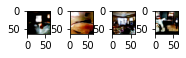

calc mean
calc sum
calc sqrt
correct covmean
calc score
[4/5][50/2369]	Loss_D: 0.6391	Loss_G: 1.3009	D(x): 0.6096	D(G(z)): 0.0381 / 0.3537
[4/5][100/2369]	Loss_D: 0.3334	Loss_G: 3.4687	D(x): 0.8716	D(G(z)): 0.1436 / 0.0510
[4/5][150/2369]	Loss_D: 0.2828	Loss_G: 3.0686	D(x): 0.7844	D(G(z)): 0.0206 / 0.0651
[4/5][200/2369]	Loss_D: 0.4772	Loss_G: 1.4579	D(x): 0.6597	D(G(z)): 0.0174 / 0.2912
[4/5][250/2369]	Loss_D: 0.8535	Loss_G: 5.5682	D(x): 0.9651	D(G(z)): 0.4858 / 0.0060
[4/5][300/2369]	Loss_D: 0.3525	Loss_G: 1.9289	D(x): 0.7978	D(G(z)): 0.0932 / 0.1825
[4/5][350/2369]	Loss_D: 0.1615	Loss_G: 3.3650	D(x): 0.9197	D(G(z)): 0.0685 / 0.0519
[4/5][400/2369]	Loss_D: 0.2294	Loss_G: 3.1068	D(x): 0.8339	D(G(z)): 0.0339 / 0.0666
[4/5][450/2369]	Loss_D: 0.3461	Loss_G: 3.4807	D(x): 0.8510	D(G(z)): 0.1420 / 0.0467
[4/5][500/2369]	Loss_D: 0.2407	Loss_G: 2.9785	D(x): 0.8833	D(G(z)): 0.0993 / 0.0683


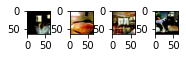

calc mean
calc sum
calc sqrt
correct covmean
calc score
[4/5][550/2369]	Loss_D: 0.2822	Loss_G: 3.9287	D(x): 0.9752	D(G(z)): 0.2105 / 0.0266
[4/5][600/2369]	Loss_D: 0.1623	Loss_G: 3.7192	D(x): 0.9740	D(G(z)): 0.1203 / 0.0335
[4/5][650/2369]	Loss_D: 0.5863	Loss_G: 1.5739	D(x): 0.8702	D(G(z)): 0.3042 / 0.2746
[4/5][700/2369]	Loss_D: 0.2636	Loss_G: 3.1911	D(x): 0.9081	D(G(z)): 0.1410 / 0.0577
[4/5][750/2369]	Loss_D: 0.1923	Loss_G: 3.8717	D(x): 0.9146	D(G(z)): 0.0894 / 0.0306
[4/5][800/2369]	Loss_D: 0.7758	Loss_G: 4.9735	D(x): 0.9602	D(G(z)): 0.4618 / 0.0103
[4/5][850/2369]	Loss_D: 0.2286	Loss_G: 3.8144	D(x): 0.9634	D(G(z)): 0.1600 / 0.0311
[4/5][900/2369]	Loss_D: 0.1842	Loss_G: 3.9518	D(x): 0.9376	D(G(z)): 0.1061 / 0.0276
[4/5][950/2369]	Loss_D: 0.3787	Loss_G: 2.3256	D(x): 0.8088	D(G(z)): 0.1211 / 0.1350
[4/5][1000/2369]	Loss_D: 0.3108	Loss_G: 2.2692	D(x): 0.8127	D(G(z)): 0.0698 / 0.1455


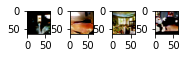

calc mean
calc sum
calc sqrt
correct covmean
calc score
[4/5][1050/2369]	Loss_D: 0.1567	Loss_G: 3.1570	D(x): 0.9043	D(G(z)): 0.0466 / 0.0605
[4/5][1100/2369]	Loss_D: 0.2676	Loss_G: 4.2334	D(x): 0.9586	D(G(z)): 0.1893 / 0.0201
[4/5][1150/2369]	Loss_D: 0.2269	Loss_G: 4.1861	D(x): 0.9515	D(G(z)): 0.1500 / 0.0216
[4/5][1200/2369]	Loss_D: 1.0281	Loss_G: 10.7977	D(x): 0.9819	D(G(z)): 0.5569 / 0.0000
[4/5][1250/2369]	Loss_D: 0.3511	Loss_G: 3.3597	D(x): 0.8862	D(G(z)): 0.1799 / 0.0512
[4/5][1300/2369]	Loss_D: 0.3314	Loss_G: 4.7226	D(x): 0.9813	D(G(z)): 0.2447 / 0.0125
[4/5][1350/2369]	Loss_D: 0.1729	Loss_G: 3.4963	D(x): 0.9130	D(G(z)): 0.0728 / 0.0452
[4/5][1400/2369]	Loss_D: 1.2672	Loss_G: 0.0562	D(x): 0.3603	D(G(z)): 0.0029 / 0.9487
[4/5][1450/2369]	Loss_D: 0.2547	Loss_G: 3.0886	D(x): 0.8673	D(G(z)): 0.0922 / 0.0647
[4/5][1500/2369]	Loss_D: 0.3842	Loss_G: 2.7961	D(x): 0.7291	D(G(z)): 0.0278 / 0.0936


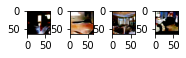

calc mean
calc sum
calc sqrt
correct covmean
calc score
[4/5][1550/2369]	Loss_D: 0.1985	Loss_G: 3.4043	D(x): 0.8951	D(G(z)): 0.0725 / 0.0515
[4/5][1600/2369]	Loss_D: 0.1662	Loss_G: 3.5275	D(x): 0.8803	D(G(z)): 0.0285 / 0.0511
[4/5][1650/2369]	Loss_D: 1.8563	Loss_G: 4.6851	D(x): 0.9126	D(G(z)): 0.7316 / 0.0197
[4/5][1700/2369]	Loss_D: 0.4934	Loss_G: 4.9472	D(x): 0.9315	D(G(z)): 0.2991 / 0.0122
[4/5][1750/2369]	Loss_D: 0.3000	Loss_G: 2.6482	D(x): 0.7920	D(G(z)): 0.0331 / 0.1038
[4/5][1800/2369]	Loss_D: 0.3427	Loss_G: 4.9782	D(x): 0.9648	D(G(z)): 0.2390 / 0.0095
[4/5][1850/2369]	Loss_D: 0.3304	Loss_G: 3.7315	D(x): 0.9399	D(G(z)): 0.2094 / 0.0358
[4/5][1900/2369]	Loss_D: 0.2163	Loss_G: 2.6545	D(x): 0.8758	D(G(z)): 0.0685 / 0.0955
[4/5][1950/2369]	Loss_D: 0.2460	Loss_G: 2.2215	D(x): 0.8346	D(G(z)): 0.0496 / 0.1421
[4/5][2000/2369]	Loss_D: 0.4343	Loss_G: 5.0954	D(x): 0.9610	D(G(z)): 0.2704 / 0.0113


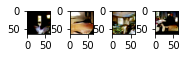

calc mean
calc sum
calc sqrt
correct covmean
calc score
[4/5][2050/2369]	Loss_D: 0.2280	Loss_G: 2.8371	D(x): 0.8484	D(G(z)): 0.0432 / 0.0800
[4/5][2100/2369]	Loss_D: 0.2769	Loss_G: 3.2086	D(x): 0.8983	D(G(z)): 0.1402 / 0.0526
[4/5][2150/2369]	Loss_D: 0.2847	Loss_G: 2.3584	D(x): 0.8256	D(G(z)): 0.0699 / 0.1238
[4/5][2200/2369]	Loss_D: 0.9958	Loss_G: 2.0809	D(x): 0.4475	D(G(z)): 0.0160 / 0.2175
[4/5][2250/2369]	Loss_D: 0.3132	Loss_G: 3.7674	D(x): 0.9270	D(G(z)): 0.1785 / 0.0343
[4/5][2300/2369]	Loss_D: 0.2388	Loss_G: 4.1407	D(x): 0.9619	D(G(z)): 0.1679 / 0.0226
[4/5][2350/2369]	Loss_D: 0.2294	Loss_G: 3.3628	D(x): 0.8243	D(G(z)): 0.0176 / 0.0532


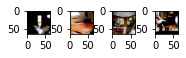

calc mean
calc sum
calc sqrt
correct covmean
calc score


In [31]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
fid = []

real_img = vutils.make_grid(real_batch[0].to(device)[:1], padding=0, normalize=True).cpu().numpy()
act1 = np.transpose(real_img, (2, 0, 1)).reshape(3,-1)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            plt.figure()
            i = 0
            for im in fake:
                i += 1
                plt.subplot(8, 8, i)
                plt.imshow(np.transpose(im,(1,2,0)))
            plt.show()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            fake_img = vutils.make_grid(fake[0].to(device)[:1], padding=0, normalize=True).cpu().numpy()
            act2 = np.transpose(fake_img, (2, 0, 1)).reshape(3,-1)
            fid_value = calculate_fid(act1, act2)
            fid.append(fid_value)
            
        iters += 1

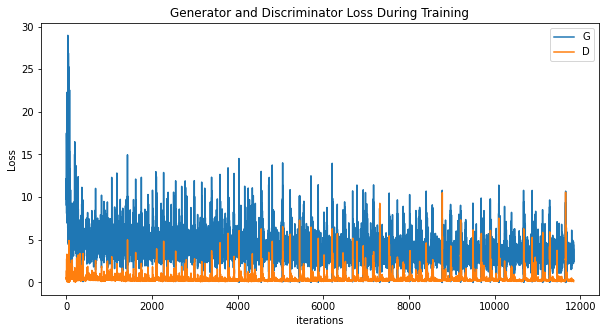

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

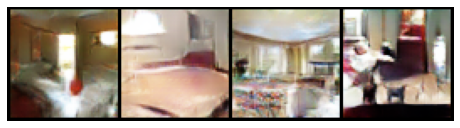

In [33]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

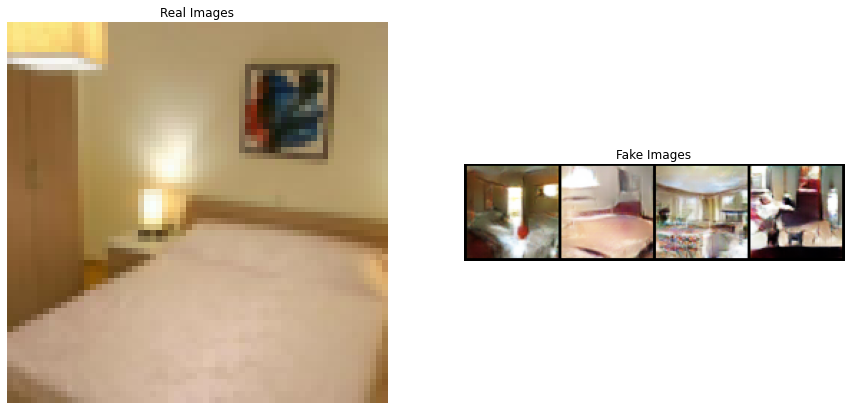

In [42]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:1], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

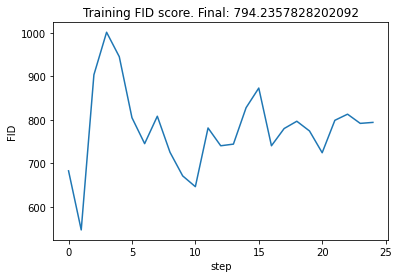

In [39]:
plt.plot(fid)
plt.xlabel('step')
plt.ylabel('FID')
plt.title(f'Training FID score. Final: {fid[-1]}');